# Diabetes Risk Prediction — Model Tuning
## Author: Mohamed Makki
#### Date&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: Nov 11th, 2025
#### Project&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: diabetes-risk-xai
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MIT ELO2 Capstone Project

### Tuning & Model Improvement
### 04_tuning.ipynb

#### 1. Importing Packages

In [12]:
# Imports & plotting setup
import os
from pathlib import Path
import joblib
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline

import xgboost as xgb
from scipy.stats import randint as sp_randint, uniform as sp_uniform

sns.set_style('whitegrid')                  # Sets Seaborn’s background style
plt.rcParams.update({"figure.dpi":150})     # Updates resolution (dots per inch)

#### 2. Paths and folders

In [2]:
# Paths (adjust to your exact local path)
PROJECT_ROOT = r"C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai"
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")   # <- project root results (as you requested)
MILESTONE_DIR = os.path.join(PROJECT_ROOT, "milestones", "milestone4_model_tuning")
NOTEBOOKS_DIR = os.path.join(MILESTONE_DIR, "notebooks")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MILESTONE_DIR, exist_ok=True)
os.makedirs(NOTEBOOKS_DIR, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai


#### 3. Load baseline model, scaler, dataset

In [3]:
# Load baseline artifacts and dataset
model_file = os.path.join(MODELS_DIR, "xgb_final_model.joblib")
scaler_file = os.path.join(MODELS_DIR, "scaler.joblib")
assert os.path.exists(model_file), f"Baseline model not found at {model_file}"
assert os.path.exists(scaler_file), f"Scaler not found at {scaler_file}"

baseline_model = joblib.load(model_file)
scaler = joblib.load(scaler_file)
print("Loaded baseline model and scaler.")

# Data
data = pd.read_csv(os.path.join(DATA_DIR, "pima.csv"))
X = data.drop(columns=["Outcome"])
y = data["Outcome"]
feature_names = X.columns.tolist()
print("Data shape:", X.shape)

Loaded baseline model and scaler.
Data shape: (768, 8)


#### 4. Split & scale

In [4]:
# Recreate train/test split and apply saved scaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (614, 8) (154, 8)


#### 5. Baseline eval

In [5]:
# Baseline evaluation (for comparison)
y_pred_base = baseline_model.predict(X_test_scaled)
y_proba_base = baseline_model.predict_proba(X_test_scaled)[:,1]
print("Baseline classification report:")
print(classification_report(y_test, y_pred_base, digits=4))

base_metrics = {
    'accuracy': float(accuracy_score(y_test, y_pred_base)),
    'precision': float(precision_score(y_test, y_pred_base)),
    'recall': float(recall_score(y_test, y_pred_base)),
    'roc_auc': float(roc_auc_score(y_test, y_proba_base))
}
open(os.path.join(RESULTS_DIR, 'baseline_metrics.json'), 'w').write(json.dumps(base_metrics, indent=2))
print("Saved baseline metrics to results/baseline_metrics.json")

Baseline classification report:
              precision    recall  f1-score   support

           0     0.7563    0.9000    0.8219       100
           1     0.7143    0.4630    0.5618        54

    accuracy                         0.7468       154
   macro avg     0.7353    0.6815    0.6919       154
weighted avg     0.7416    0.7468    0.7307       154

Saved baseline metrics to results/baseline_metrics.json


#### 6. Define model & param space

In [7]:
# Define estimator and search space
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': sp_randint(50, 400),
    'max_depth': sp_randint(3, 10),
    'learning_rate': sp_uniform(0.01, 0.3),
    'subsample': sp_uniform(0.5, 0.5),
    'colsample_bytree': sp_uniform(0.5, 0.5),
    'gamma': sp_uniform(0, 5),
    'reg_alpha': sp_uniform(0, 1),
    'reg_lambda': sp_uniform(0, 2)
}
pipeline = Pipeline([('clf', xgb_clf)])

#### 7. RandomizedSearchCV (tuning)

In [8]:
# Randomized search setup
scoring = 'recall'   # primary objective
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_iter = 40   # adjust if you want more thorough search

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={'clf__' + k: v for k, v in param_dist.items()},
    n_iter=n_iter,
    scoring=scoring,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("Starting RandomizedSearchCV (this can take several minutes depending on n_iter and n_jobs)...")
random_search.fit(X_train_scaled, y_train)

best_est = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best CV recall:", best_score)
print("Best params:", best_params)

# Save tuned model
joblib.dump(best_est, os.path.join(MODELS_DIR, "xgb_tuned.joblib"))
print("Saved tuned model to models/xgb_tuned.joblib")

Starting RandomizedSearchCV (this can take several minutes depending on n_iter and n_jobs)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:51:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV recall: 0.6262458471760797
Best params: {'clf__colsample_bytree': np.float64(0.9438850493804799), 'clf__gamma': np.float64(4.254642243837564), 'clf__learning_rate': np.float64(0.29069049826628424), 'clf__max_depth': 6, 'clf__n_estimators': 153, 'clf__reg_alpha': np.float64(0.6064290596595899), 'clf__reg_lambda': np.float64(0.018394103233259296), 'clf__subsample': np.float64(0.5507357714330161)}
Saved tuned model to models/xgb_tuned.joblib


#### 8. Evaluate tuned model

In [9]:
# Evaluate tuned model on test set
y_pred = best_est.predict(X_test_scaled)
y_proba = best_est.predict_proba(X_test_scaled)[:,1]

metrics = {
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred)),
    'recall': float(recall_score(y_test, y_pred)),
    'f1': float(f1_score(y_test, y_pred)),
    'roc_auc': float(roc_auc_score(y_test, y_proba))
}
open(os.path.join(RESULTS_DIR, 'best_model_metrics.json'), 'w').write(json.dumps(metrics, indent=2))
print("Test metrics:\n", json.dumps(metrics, indent=2))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Test metrics:
 {
  "accuracy": 0.7337662337662337,
  "precision": 0.6226415094339622,
  "recall": 0.6111111111111112,
  "f1": 0.616822429906542,
  "roc_auc": 0.8225925925925927
}
Confusion matrix:
 [[80 20]
 [21 33]]


#### 9. Save tuning log

In [10]:
# Save human-readable tuning log to the milestone folder (as you requested)
log_path = os.path.join(MILESTONE_DIR, 'tuning_log.txt')
with open(log_path, 'w', encoding='utf-8') as f:
    f.write('RandomizedSearchCV tuning log\n')
    f.write(f'Run time: {time.asctime()}\n')
    f.write(f'Param distribution keys: {list(param_dist.keys())}\n')
    f.write(f'Best params: {best_params}\n')
    f.write(f'Best CV recall: {best_score}\n')
    f.write('Test metrics:\n')
    f.write(json.dumps(metrics, indent=2))
print("Tuning log saved to", log_path)

Tuning log saved to C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai\milestones\milestone4_model_tuning\tuning_log.txt


#### 10. Calibration curve & SHAP summary 

Saved calibration and SHAP plots to results/


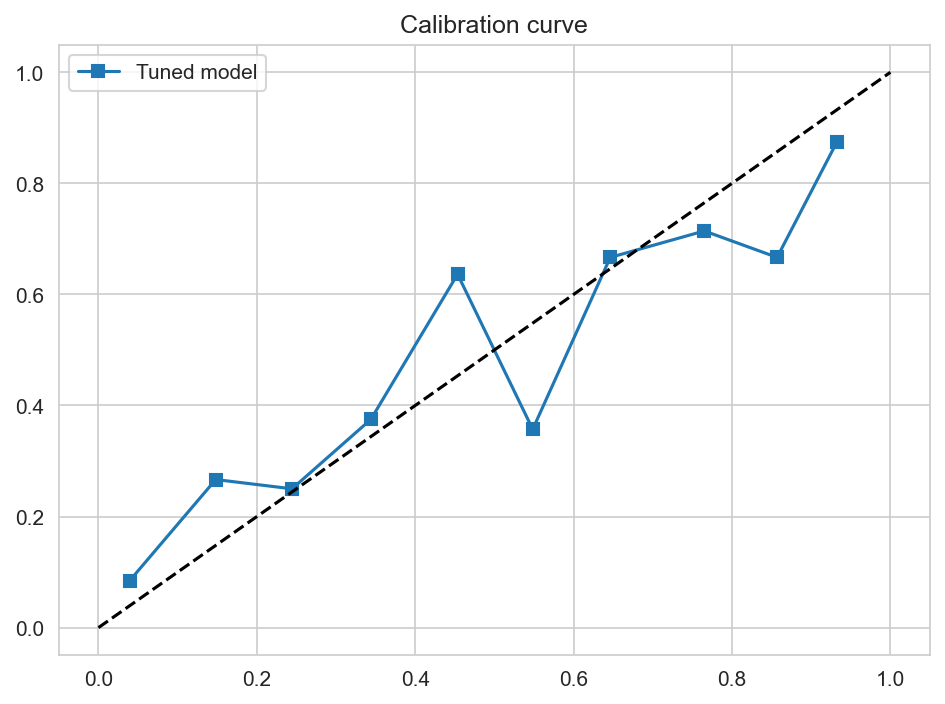

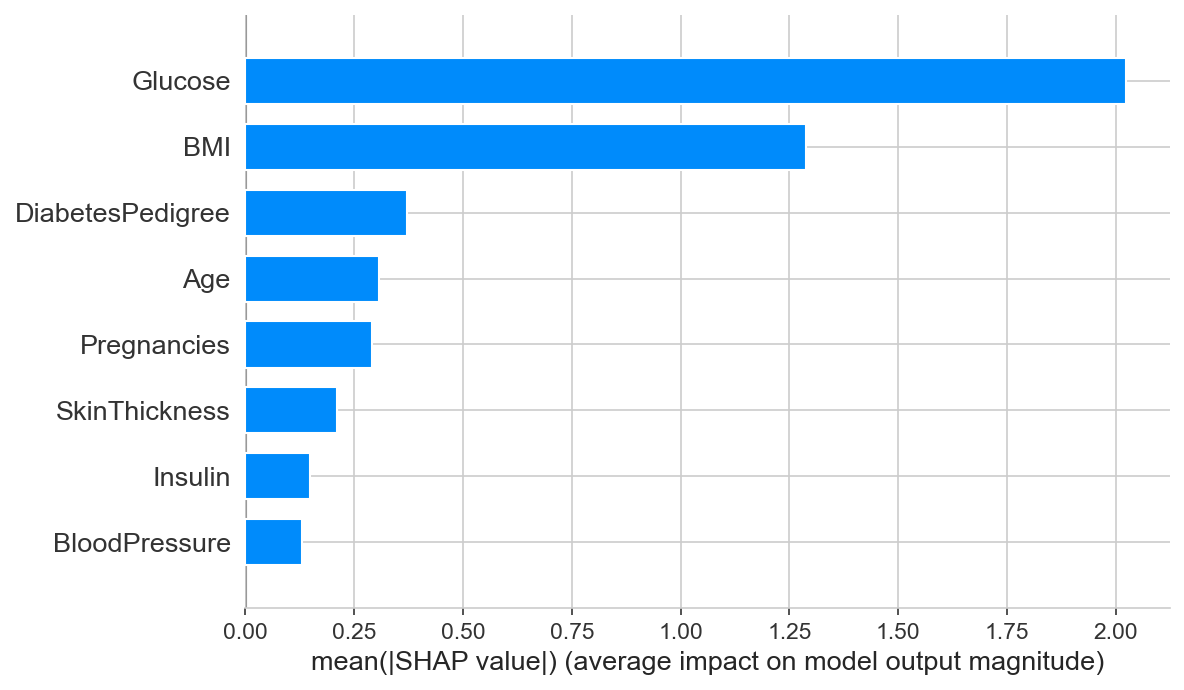

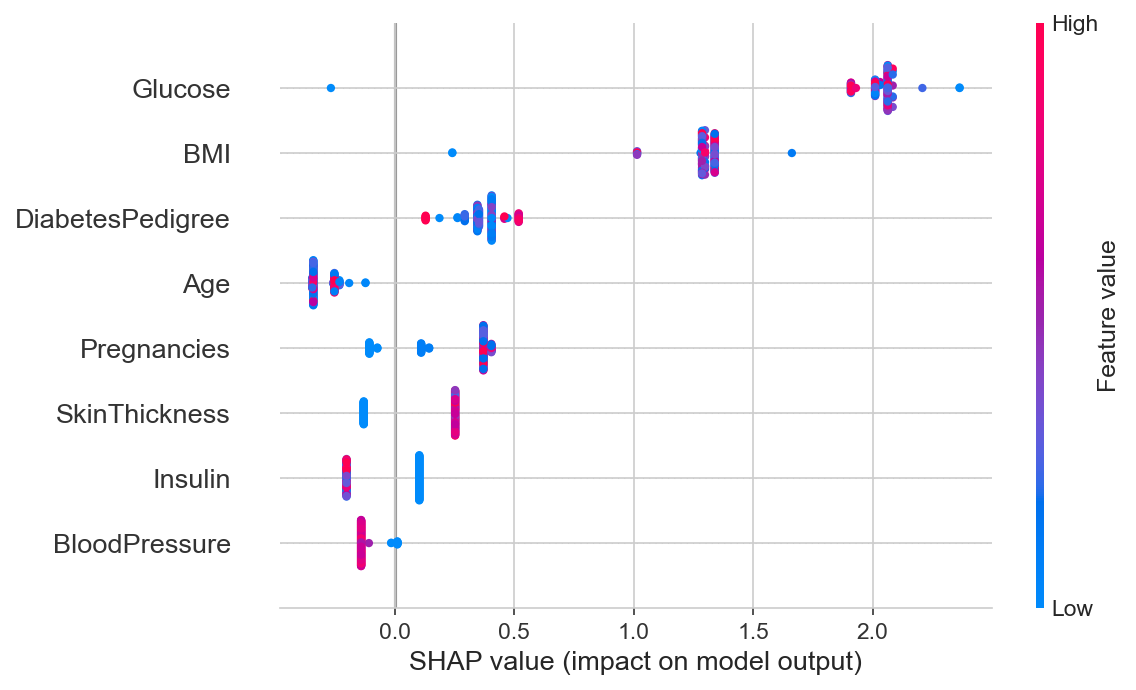

In [11]:
# Calibration curve
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(); plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Tuned model'); plt.plot([0,1],[0,1],'k--'); plt.legend(); plt.title('Calibration curve'); plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'calibration_curve_tuned.png'), dpi=300)

# SHAP summary on unscaled features
import shap
best_booster = best_est.named_steps['clf']
explainer = shap.TreeExplainer(best_booster)
X_test_df = pd.DataFrame(X_test.reset_index(drop=True), columns=feature_names)
shap_values = explainer.shap_values(X_test_df)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_arr = shap_values[1]
else:
    shap_arr = shap_values

plt.figure(); shap.summary_plot(shap_arr, X_test_df, plot_type='bar', show=False); plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR,'shap_summary_bar_tuned.png'), dpi=300)
plt.figure(); shap.summary_plot(shap_arr, X_test_df, plot_type='dot', show=False); plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR,'shap_summary_beeswarm_tuned.png'), dpi=300)
print("Saved calibration and SHAP plots to results/")

#### 11. Final notes

### End of tuning notebook

- Inspect `milestones/milestone4_model_tuning/tuning_log.txt` for the human-readable summary.
- Check `results/` for saved plots and `models/xgb_tuned.joblib` for the tuned model.
- If the tuned model improved recall and other metrics, consider promoting `xgb_tuned.joblib` as 
  the new production model and updating the Streamlit app in Milestone 5.
